## Почасовой прогноз

In [2090]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

import warnings
warnings.simplefilter("ignore")

In [2091]:
energo = pd.read_csv('result.csv')

In [2092]:
labels = [
    # 'Генерация, МВт*ч\\',
    # 'T',
    # 'Po',
    # 'U', 'Ff', 'VV'
]
target = 'Потребление, МВт*ч'
names = labels + [target]

In [2093]:
energo = energo[names]

In [2094]:
four_old = energo.iloc[: 24 * 7 * 4]
n_four_old = four_old.shape[0]
n_four_old

672

In [2095]:
three_new = energo.iloc[energo.shape[0] - 24 * 7 * 3 -24*7 : -24*7]
n_three_new = three_new.shape[0]
n_three_new

504

In [2096]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.concat((four_old, three_new)))

In [2097]:
preemption = 24 * 3

In [2098]:
train_x = ([scaler.transform(four_old)[i: i+preemption] for i in range(n_four_old - preemption)] +
    [scaler.transform(three_new)[i: i+preemption] for i in range(n_three_new - preemption)])

In [2099]:
sh = np.array(train_x).shape[2]
s_train_x = [[] for _ in range(sh)]

for i in train_x:
    for j in range(sh):
        s_train_x[j].append(i.T[j])

In [2100]:
gr_train_x = list(map(np.concatenate, train_x))

In [2101]:
train_subs = np.concatenate((scaler.transform(four_old)[preemption-n_four_old:],
    scaler.transform(three_new)[preemption-n_three_new:])).T

In [2102]:
train_y = train_subs[-1]

In [2103]:
sub_models = [MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1) for _ in train_subs[:-1]]
g_model = MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1)

In [2104]:
g_model.fit(gr_train_x, train_y)

MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1)

In [2105]:
for i in tqdm.tqdm(range(len(sub_models))):
    sub_models[i].fit(s_train_x[i], train_subs[i])

0it [00:00, ?it/s]


In [2106]:
series = scaler.transform(three_new)[-preemption:].T.tolist()

In [2107]:
for _ in tqdm.tqdm(range(24*7)):
    for i in range(sh-1):
        series[i].append(sub_models[i].predict([series[i][-preemption:]])[0])

100%|████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 167772.16it/s]


In [2108]:
for _ in tqdm.tqdm(range(24*7)):
    s = np.array([i[-preemption:] for i in series]).reshape(-1)
    series[-1].append(g_model.predict([s])[0])

100%|██████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 4421.43it/s]


In [2109]:
y_true = [i[-1] for i in scaler.transform(energo.iloc[-24*7-preemption:])]

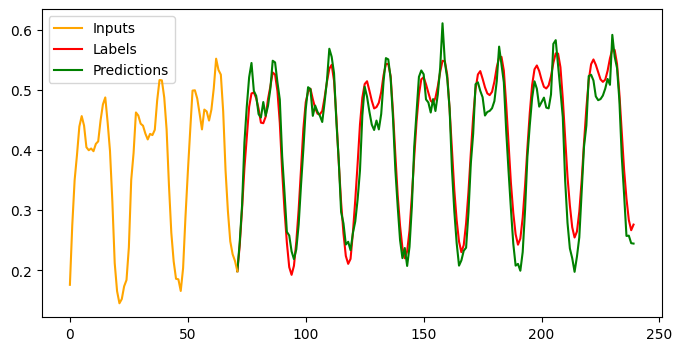

In [2110]:
r1 = np.array(range(len(y_true[:preemption])))
r2 = np.array(range(len(y_true[:preemption])-1, len(y_true)))

plt.figure(figsize=(8,4))
plt.plot(r1, y_true[:preemption], zorder=10, color='orange', label='Inputs')
plt.plot(r2, series[-1][preemption-1:], color='red', label='Labels')
plt.plot(r2, y_true[preemption-1:], color='green', label='Predictions')
_ = plt.legend()

plt.show()

In [2111]:
print("MAE:", abs(np.array(series[-1][preemption:]) - np.array(y_true[preemption:])).mean())

MAE: 0.025971322518613095


## Подневный прогноз

#### Один параметр

In [2112]:
energo = pd.read_csv('result.csv')

In [2113]:
target = 'Потребление, МВт*ч'
names = [target]

In [2114]:
days = len(energo[target])
hours = days // 24

In [2115]:
d = {i: [j.mean() for j in np.array(energo[i])[:24*hours].reshape((hours, 24))] for i in names}

In [2116]:
energo_d = pd.DataFrame(d)
energo_d.head(1)

,"Потребление, МВт*ч"
0,26522.416667


In [2117]:
n_old = 260
old = energo_d.iloc[: n_old]

In [2118]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(old)

In [2119]:
preemption = 30

In [2120]:
train_x = ([scaler.transform(old)[i: i+preemption] for i in range(n_old - preemption)])

In [2121]:
sh = np.array(train_x).shape[2]
s_train_x = [[] for _ in range(sh)]

for i in train_x:
    for j in range(sh):
        s_train_x[j].append(i.T[j])

In [2122]:
gr_train_x = list(map(np.concatenate, train_x))

In [2123]:
train_subs = scaler.transform(old)[preemption-n_old:].T

In [2124]:
train_y = train_subs[-1]

In [2125]:
g_model = MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1)

In [2126]:
g_model.fit(gr_train_x, train_y)

MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1)

In [2127]:
series = scaler.transform(old)[-preemption:].T.tolist()

In [2128]:
for _ in tqdm.tqdm(range(30)):
    s = np.array([i[-preemption:] for i in series]).reshape(-1)
    series[-1].append(g_model.predict([s])[0])

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 3749.94it/s]


In [2129]:
y_true = [i[-1] for i in scaler.transform(energo_d.iloc[-30-preemption:])]

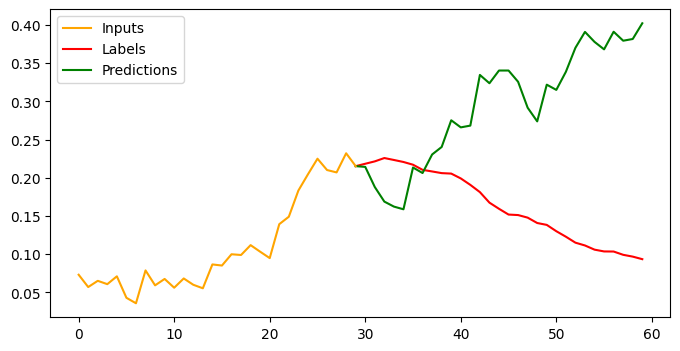

In [2130]:
r1 = np.array(range(len(y_true[:preemption])))
r2 = np.array(range(len(y_true[:preemption])-1, len(y_true)))

plt.figure(figsize=(8,4))
plt.plot(r1, y_true[:preemption], zorder=10, color='orange', label='Inputs')
plt.plot(r2, series[-1][preemption-1:], color='red', label='Labels')
plt.plot(r2, y_true[preemption-1:], color='green', label='Predictions')
_ = plt.legend()

plt.show()

In [2131]:
print("MAE:", abs(np.array(series[-1][preemption:]) - np.array(y_true[preemption:])).mean())

MAE: 0.1481311806415708


#### Несколько параметров

In [2132]:
labels = [
    'Генерация, МВт*ч\\',
    'T',
    # 'Po',
    # 'U', 'Ff', 'VV'
]
target = 'Потребление, МВт*ч'
names = labels + [target]

In [2133]:
days = len(energo[target])
hours = days // 24

In [2134]:
d = {i: [j.mean() for j in np.array(energo[i])[:24*hours].reshape((hours, 24))] for i in names}

In [2135]:
energo_d = pd.DataFrame(d)

In [2136]:
n_old = 260
old = energo_d.iloc[: n_old]

In [2137]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(old)

In [2138]:
preemption = 30

In [2139]:
train_x = ([scaler.transform(old)[i: i+preemption] for i in range(n_old - preemption)])

In [2140]:
sh = np.array(train_x).shape[2]
s_train_x = [[] for _ in range(sh)]

for i in train_x:
    for j in range(sh):
        s_train_x[j].append(i.T[j])

In [2141]:
gr_train_x = list(map(np.concatenate, train_x))

In [2142]:
train_subs = scaler.transform(old)[preemption-n_old:].T

In [2143]:
train_y = train_subs[-1]

In [2144]:
sub_models = [MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1) for _ in train_subs[:-1]]
g_model = MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1)

In [2145]:
g_model.fit(gr_train_x, train_y)

MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=1)

In [2146]:
for i in tqdm.tqdm(range(len(sub_models))):
    sub_models[i].fit(s_train_x[i], train_subs[i])

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.09it/s]


In [2147]:
series = scaler.transform(old)[-preemption:].T.tolist()

In [2148]:
for _ in tqdm.tqdm(range(30)):
    for i in range(sh-1):
        series[i].append(sub_models[i].predict([series[i][-preemption:]])[0])

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1874.91it/s]


In [2149]:
for _ in tqdm.tqdm(range(30)):
    s = np.array([i[-preemption:] for i in series]).reshape(-1)
    series[-1].append(g_model.predict([s])[0])

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 3656.87it/s]


In [2150]:
y_true = [i[-1] for i in scaler.transform(energo_d.iloc[-30-preemption:])]

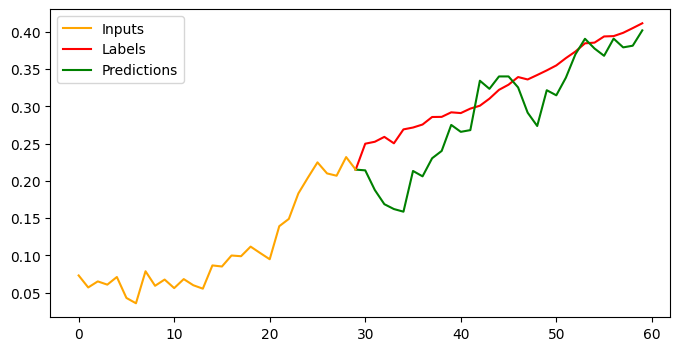

In [2151]:
r1 = np.array(range(len(y_true[:preemption])))
r2 = np.array(range(len(y_true[:preemption])-1, len(y_true)))

plt.figure(figsize=(8,4))
plt.plot(r1, y_true[:preemption], zorder=10, color='orange', label='Inputs')
plt.plot(r2, series[-1][preemption-1:], color='red', label='Labels')
plt.plot(r2, y_true[preemption-1:], color='green', label='Predictions')
_ = plt.legend()

plt.show()

In [2152]:
print("MAE:", abs(np.array(series[-1][preemption:]) - np.array(y_true[preemption:])).mean())

MAE: 0.03619022261478451
